In [1]:
import torch
from sd_pipeline import StableDiffusion3Pipeline
from sd_processor import JointAttnProcessor2_0
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=torch.bfloat16)
pipe = pipe.to("cuda")

/home/wg25r/miniconda/envs/mochi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]


In [2]:
for block in pipe.transformer.transformer_blocks:
    block.attn.processor = JointAttnProcessor2_0()

In [11]:
# prompt = "A cozy dining area bathed in morning light with polished wooden surfaces"
# negative_prompt = "there are chair, bench, and stool in the image"
# pipe.tokenizer.tokenize(negative_prompt)
# prompt = "a women standing close to the camera, no hair"
# prompt = "a beautiful landscape, in the style of Bob Ross"
prompt = "a dinning hall during the day"
# negative_prompt = "lake"
# negative_prompt = "hair is visible in the image" 
negative_prompt = "there are trees in the image" # oh i get it, the prompt, the longer it is and more unrelated it is, the more diluted it iss
# negative_prompt = "there are chairs, benches, and stools in the image" 
len(pipe.tokenizer_3.tokenize(negative_prompt)), len(pipe.tokenizer_3.tokenize(negative_prompt)), len(pipe.tokenizer_3.tokenize(negative_prompt))

(6, 6, 6)

In [4]:
for block in pipe.transformer.transformer_blocks:
    block.attn.processor.neg_prompt_len=max([
        len(pipe.tokenizer.tokenize(negative_prompt)), 
        len(pipe.tokenizer_2.tokenize(negative_prompt)),
        len(pipe.tokenizer_3.tokenize(negative_prompt))
    ]) + 1 

In [5]:
import time
import numpy as np 
from PIL import Image
seed = 1747891046#int(time.time())
image1 = pipe(
    prompt,
    negative_prompt=negative_prompt, 
    num_inference_steps=16,
    avoidance_factor=0,
    guidance_scale=8,
    generator=torch.manual_seed(seed), 
).images[0]  
image2 = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=16,
    avoidance_factor=3,
    guidance_scale=8,
    generator=torch.manual_seed(seed),  
).images[0] 


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


In [6]:
seed 

1747891046

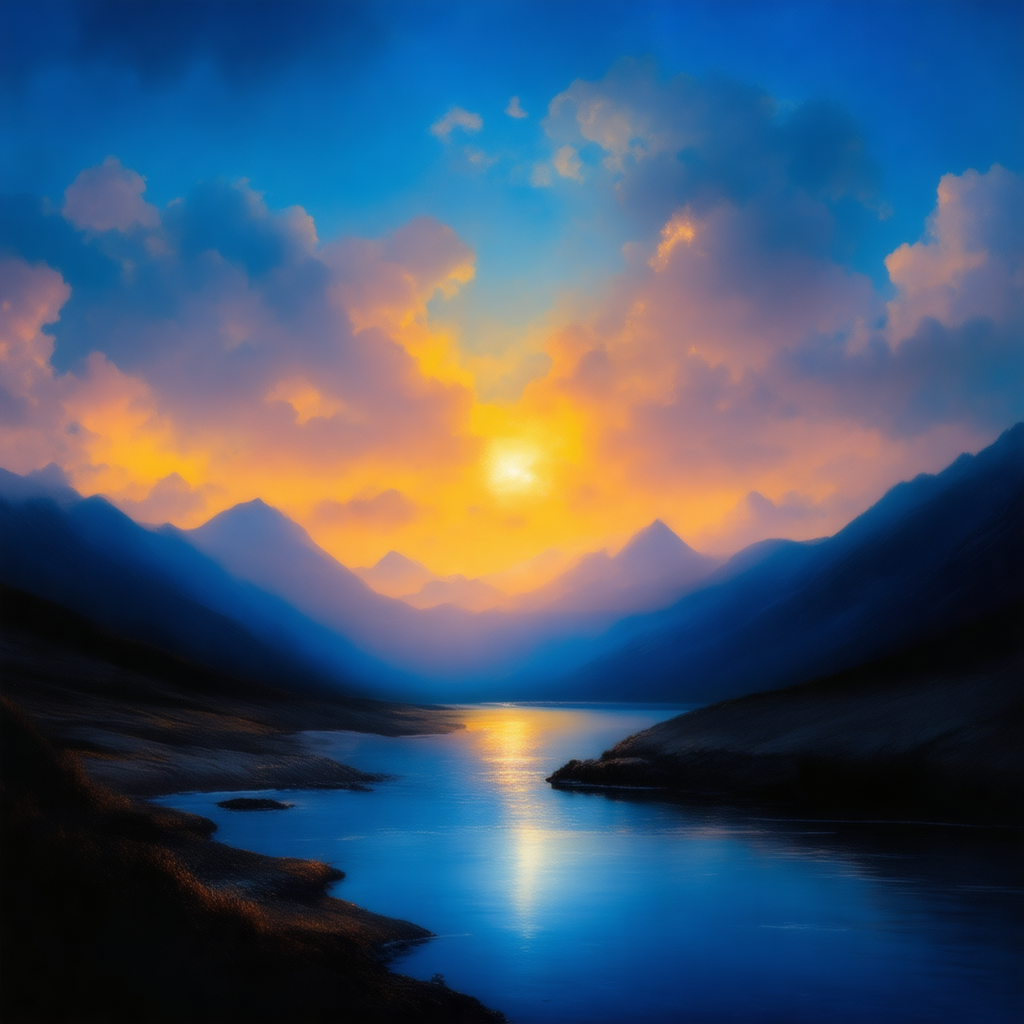

In [7]:
# Image.fromarray(np.concatenate([np.array(image1), np.array(image2)], axis=1))
image2

In [8]:
# import cv2, pylab
# img1 = np.array(image1)
# img2 = np.array(image2)
# pylab.subplot(1, 2, 1)
# pylab.imshow(img1)
# pylab.title("A")
# pylab.axis('off')
# pylab.subplot(1, 2, 2) 
# pylab.imshow(img2) 
# pylab.title("B")
# pylab.axis('off') 
# pylab.suptitle(f"Prompt: {prompt}\nNegative Prompt: {negative_prompt}\nSeed: {seed}")
# pylab.tight_layout() 

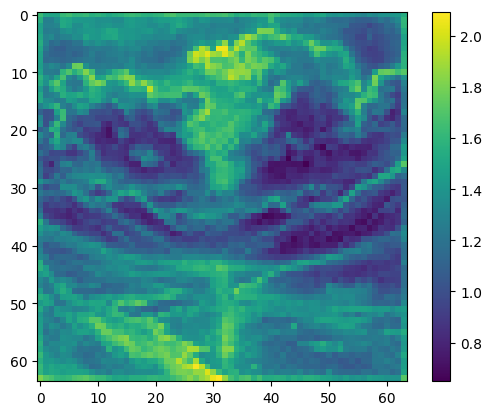

In [9]:
import pylab 
map = torch.stack(pipe.neg_maps)[-3].mean((0,1,2,3)).reshape(64, 64).cpu().float().numpy()
pylab.imshow(map)
pylab.colorbar()

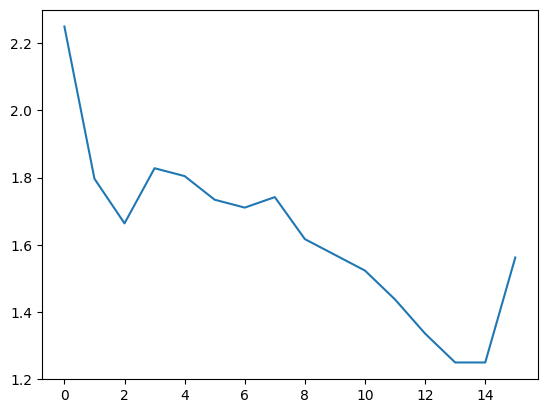

In [10]:
pylab.plot(torch.stack(pipe.neg_maps).mean((1,2,3,4)).abs().mean(-1).cpu().float().numpy())